<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab3_Coupled_Oscillator/blob/main/Lab3_Weakly_dumped_forced_oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3. Weakly dumped forced oscillator animation

Evgeny Kolonsky 2025

Code originated from [stackoverflow](https://stackoverflow.com/questions/67498084/animating-damped-oscillator)

v.0.1.4



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from scipy.signal import find_peaks

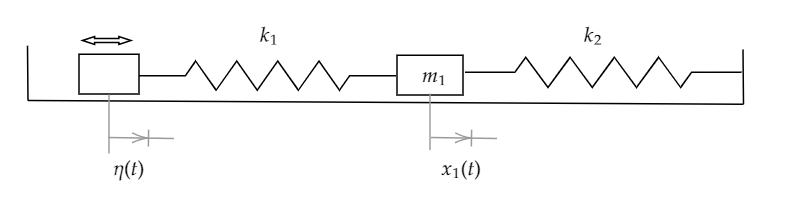

Motion equation

$$
\ddot x + \frac{1}{\tau} \dot x + \omega_0^2 x = \eta_0 \frac{k_1}{k_1+k_2}\omega_0^2 \cos \omega t, \qquad \omega_0^2 = \frac{k_1+k_2}{m}
$$

Constants and parameters

In [2]:
# Constants and parameters
# general geometry
k1_length = 20e-2 # m, length of spring
sensor_width = 12e-2 # width of sensor

# elastic coefficients
k1 = 4.6 # N/m
k2 = 6.2 # N/m
k = k1 + k2 # total elastic coefficient
# oscillator mass
m = 217e-3 # kg
# Quality
tau = 3 #s viscous friction parameter
# natural frequency
w0 = np.sqrt(k / m) # natural frequency
f0 = w0 / (2 * np.pi) # natural frequency in Hz

# external force
f = 1.02 # Hz
w = 2 * np.pi * f #angular frequency
eta0 = 1e-2 # external force amplitude

print(f'natural frequency:  {f0:.3f} Hz')
print(f'external frequency: {f:.3f} Hz')

# Initial conditions
x0 =  0. #Initial x position, m
vx0 = 0. #Initial x Velocity, m/s

# Setting time array for graph visualization
dt = 0.05 #s
Tmax = 20 #s, animation time
N = int(Tmax / dt) # number of frames
# skip some frames to speed up animation
frame_step = 1
interval = dt * 1000 * frame_step


natural frequency:  1.123 Hz
external frequency: 1.020 Hz


# Numeric functions

In [3]:
def get_stationary(t, xa, x):
  ix = t > np.max(t) - tau
  return t[ix], xa[ix], x[ix]

def get_freq(t, signal):

  peaks, _ = find_peaks(signal)
  t1 = t[peaks]
  T = np.mean(np.diff(t1))
  return 1 / T

def show(t, xa, x, animate=False):

  # Plot
  fig, ax = plt.subplots(1,1, figsize=(8,8))
  f = get_freq(t, xa)
  ax.set_title(f'Driver frequency {f:.2f} Hz           Natural frequency {f0:.2f} Hz')

  spring, = ax.plot([], [], lw=10,c="blue",ls="-",ms=20,marker="s",
                    mfc="r",fillstyle="none",mec="r",markevery=1)
  timeline_x = Line2D([], [])
  timeline_xa = Line2D([], [])
  ax.add_line(timeline_x)
  ax.add_line(timeline_xa)
  time_template = '\nTime = %.1fs'
  time_text = ax.text(0.2, 0.9, '', transform=ax.transAxes)

  ax.set_xlim(-k1_length - sensor_width/2 ,  sensor_width/2)


  # Represent displacement in cm
  ax.xaxis.set_major_formatter(lambda x, pos: f'{x*100:.0f}')
  ax.set_xlabel('Displacement, cm')

  # represent time in s
  ax.set_ylim(-Tmax, 1)
  ax.set_ylabel('Time, s')
  ax.axvline(x=-k1_length, color='k', linestyle='--')
  ax.axvline(x=0, color='k', linestyle='--')

  spring.set_data([x[-1],xa[-1]], [0,0])
  elastic_extension = (x[-1] - xa[-1]) / k1_length
  spring.set_linewidth(10 / elastic_extension)
  timeline_x.set_data(x, t - t[-1])
  timeline_xa.set_data(xa, t - t[-1])

  ax.plot()

  if animate:
    def init():
        spring.set_data([], [])
        timeline_x.set_data([], [])
        timeline_xa.set_data([], [])
        time_text.set_text('')
        return spring, timeline_x, timeline_xa, time_text

    def animate(i):
        spring.set_data([x[i],xa[i]], [0,0])
        elastic_extension = (x[i] - xa[i]) / k1_length
        spring.set_linewidth(10 / elastic_extension)
        timeline_x.set_data(x[:i], t[:i] - t[i])
        timeline_xa.set_data(xa[:i], t[:i] - t[i])
        time_text.set_text(time_template % (i*dt))
        return spring, timeline_x,  timeline_xa, time_text

    ani = animation.FuncAnimation(fig, animate, np.arange(1, N, frame_step),
                    interval=interval, blit=True, init_func=init,repeat=False)

    # save as gif
    #ani.save('oscillator.gif')
    # Option - save as html
    with open("oscillator.html", "w") as savefile:
        print(ani.to_html5_video(), file=savefile)

  return

def save(t, xa, x, filename):
    # save result
    data = np.array([t, xa, x]).T
    np.savetxt(filename, data, delimiter=',',
              header=f't, xa, xb', fmt='%.4f')
    print(f'Saved to {filename}')
    return

In [4]:
def get_solution(w, Tmax=Tmax):

  #Function that returns dX/dt for the linearly damped oscillator
  def dXdt(t, X):
      x = X[0]
      vx = X[1]
      ax = - vx / tau - w0**2 * x + eta0 * w0**2 * k1/k * np.cos(w * t)
      return np.array([vx, ax])

  #Function that implements rk4 integration
  def rk4(t, x, func, dt):
      dx1 = func(t, x)*dt
      dx2 = func(t+0.5*dt, x+0.5*dx1)*dt
      dx3 = func(t+0.5*dt, x+0.5*dx2)*dt
      dx4 = func(t+dt, x+dx3)*dt
      return x+dx1/6.0+dx2/3.0+dx3/3.0+dx4/6.0

  N = int(Tmax / dt) # number of frames
  t = np.linspace(0, Tmax, N, endpoint=False)
  x = np.zeros(N)
  vx = np.zeros(N)
  # external force cart coordinate
  xa = eta0 * np.cos(w * t) - k1_length

  # integrate equations of motion using rk4;
  # X is a vector that contains the positions and velocities being integrated
  X = np.array([x0, vx0])

  for i in range(N):
      x[i] = X[0]
      vx[i] = X[1]
      # update the vector X to the next time step
      X = rk4(i*dt, X, dXdt, dt)

  return t, xa, x



# Solve and animate

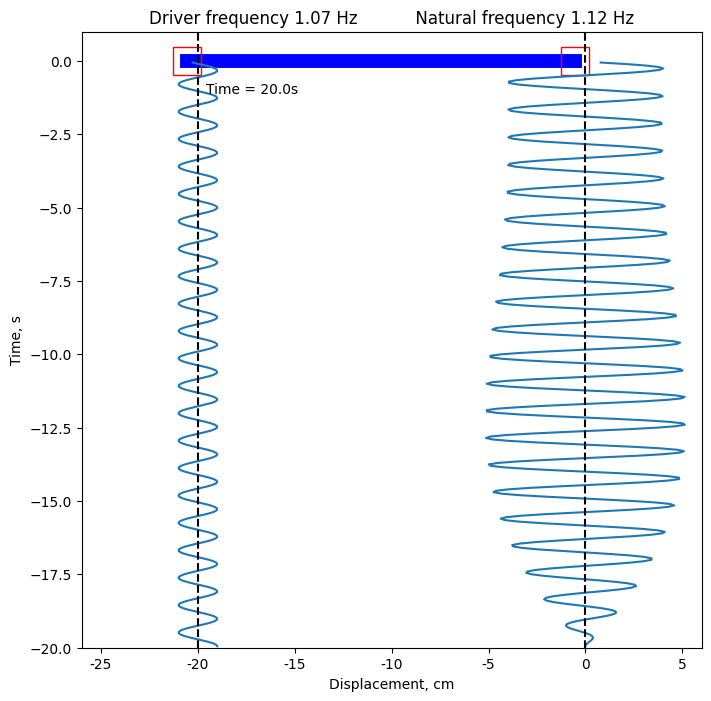

In [5]:
t, xa, x = get_solution(1.07*2*np.pi, Tmax=10*tau)
show(t, xa, x, animate=True)

# Amplitude and phase response curve



In [6]:
def amp_observed(signal):
  signal -= np.mean(signal)
  peaks, _ = find_peaks(signal, height = np.max(signal)/2)
  return np.mean(signal[peaks])


def get_response(t, xa, x):
  t, xa, x = get_stationary(t, xa, x)
  xa = xa - np.mean(xa)
  amp_driver = amp_observed(xa)
  amp_osc    = amp_observed(x)
  cosphi = xa @ x / np.sqrt(xa @ xa * x@x)
  response = amp_osc / amp_driver
  return amp_osc / amp_driver, cosphi

def amp_expected(w):
  return  k1/ m / np.sqrt((w0**2 - w**2)**2 + (w / tau)**2)

def cosphi_expected(w):
  phi = np.arctan( - (w / tau) / (w0**2 - w**2))

  phi = np.array([p +  np.pi if p > 0 else p for p in phi])
  return  np.cos(phi)



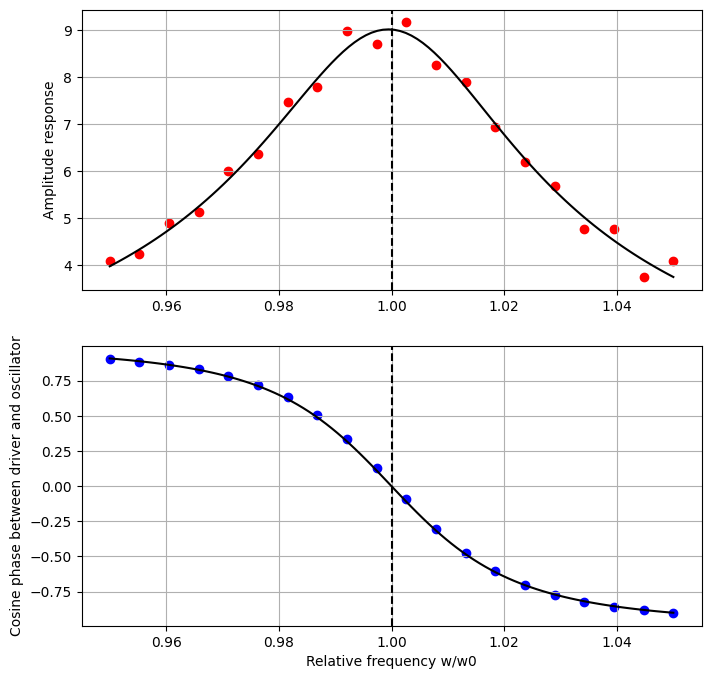

In [7]:
fig, ax = plt.subplots(2,1, figsize=(8,8))

wmin, wmax = 0.95, 1.05 # relative freq
for w in np.linspace(wmin, wmax, 20) * w0:
  t, xa, x = get_solution(w, Tmax=30*tau)
  t, xa, x = get_stationary(t, xa, x)
  response, cosphi = get_response(t, xa, x)
  #print(f'{w:.2f} {response:>.2f} {cosphi:>.2f}')
  ax[0].scatter(w/w0, response, color='red')
  ax[1].scatter(w/w0, cosphi, color='blue')
plt.xlabel('Relative frequency w/w0')
ax[0].set_ylabel('Amplitude response')
ax[1].set_ylabel('Cosine phase between driver and oscillator')
ax[0].axvline(x=1, color='k', linestyle='--')
ax[1].axvline(x=1, color='k', linestyle='--')
ax[0].grid()
ax[1].grid()

w = np.linspace(wmin, wmax, 100) *w0
ax[0].plot(w/w0, amp_expected(w), color='black')
ax[1].plot(w/w0, cosphi_expected(w), color='black')
plt.show()
